# ABC Guide for XMM-Newton -- Part 1

---

#### Introduction
This tutorial is based on Chapter 6 from the The XMM-Newton ABC Guide prepared by the NASA/GSFC XMM-Newton Guest Observer Facility. This notebook assumes you are at least minimally familiar with pySAS on SciServer (see the [Long pySAS Introduction](./xmm-pysas-intro-long.ipynb "Long pySAS Intro")). 
#### Expected Outcome
The ability to apply basic filters to any XMM-Newton observation and prepare it for analysis.
#### SAS Tasks to be Used

- `emproc`[(Documentation for emproc)](https://xmm-tools.cosmos.esa.int/external/sas/current/doc/emproc/index.html "emproc Documentation")
- `epproc`[(Documentation for epproc)](https://xmm-tools.cosmos.esa.int/external/sas/current/doc/epproc/index.html "epproc Documentation")
- `evselect`[(Documentation for evselect)](https://xmm-tools.cosmos.esa.int/external/sas/current/doc/evselect/index.html)
- `tabgtigen`[(Documentation for tabgtigen)](https://xmm-tools.cosmos.esa.int/external/sas/current/doc/tabgtigen/index.html)
- `gtibuild`[(Documentation for gtibuild)](https://xmm-tools.cosmos.esa.int/external/sas/current/doc/gtibuild/index.html)

#### Prerequisites
On SciServer both SAS and HEASOFT are automatically initialized when opening a container and starting a kernal.
#### Useful Links

- [`pysas` Documentation](https://xmm-tools.cosmos.esa.int/external/sas/current/doc/pysas/index.html "pysas Documentation")
- [Common SAS Threads](https://www.cosmos.esa.int/web/xmm-newton/sas-threads/index.html "SAS Threads")
- [Users' Guide to the XMM-Newton Science Analysis System (SAS)](https://xmm-tools.cosmos.esa.int/external/xmm_user_support/documentation/sas_usg/USG/SASUSG.html "Users' Guide")
- [The XMM-Newton ABC Guide](https://heasarc.gsfc.nasa.gov/docs/xmm/abc/ "ABC Guide")
- [XMM Newton GOF Helpdesk](https://heasarc.gsfc.nasa.gov/docs/xmm/xmm_helpdesk.html "Helpdesk") - Link to form to contact the GOF Helpdesk.

#### Caveats
This tutorial uses an observation of the Lockman Hole (obsid = '0123700101'). The following assumes this notebook is run from the <tt>(xmmsas)</tt> environment on SciServer. You should see <tt>(xmmsas)</tt> at the top right of the notebook. If not, click there and select <tt>(xmmsas)</tt>.


##### Last Reviewed: _20 January 2024, for SAS v21_
##### Last Updated: _20 January 2024_
---

In [1]:
# pySAS imports
import pysas
from pysas.wrapper import Wrapper as w

# Useful imports
import os

# Imports for plotting
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
plt.style.use(astropy_mpl_style)

### 6.1 : Rerun basic processing

In [2]:
obsid = '0123700101'
odf = pysas.odfcontrol.ODFobject(obsid)
odf.basic_setup(overwrite=False,repo='heasarc',
                rerun=False, epproc_args=['withoutoftime=yes'])



        Starting SAS session

        Data directory = /home/rtanner2/xmm_data

        
SAS_CCF = /home/rtanner2/xmm_data/0123700101/work/ccf.cif
SAS_ODF = /home/rtanner2/xmm_data/0123700101/work/0070_0123700101_SCX00000SUM.SAS
['withoutoftime=yes']
   SAS command to be executed: epproc, with arguments; 
['withoutoftime=yes']
Running epproc ..... 

 > 1 EPIC-pn event list found. Not running epproc again.

    /home/rtanner2/xmm_data/0123700101/work/0070_0123700101_EPN_S003_ImagingEvts.ds

..... OK
[]
   SAS command to be executed: emproc, with arguments; 
[]
Running emproc ..... 

 > 2 EPIC-MOS1 event list found. Not running emproc again.

    /home/rtanner2/xmm_data/0123700101/work/0070_0123700101_EMOS1_S001_ImagingEvts.ds

    /home/rtanner2/xmm_data/0123700101/work/0070_0123700101_EMOS1_U002_ImagingEvts.ds

 > 1 EPIC-MOS2 event list found. Not running emproc again.

    /home/rtanner2/xmm_data/0123700101/work/0070_0123700101_EMOS2_S002_ImagingEvts.ds

..... OK


If the dataset has more than one exposure, a specific exposure can be accessed using the <tt>withinstexpids</tt> and <tt>instexpids</tt> parameters, e.g.:

```python
inargs = "withinstexpids=yes instexpids='M1S001 M2S001'"
w('emproc', inargs).run()
```

<div class="alert alert-block alert-info">
    <b>Note:</b> For PN observations with very bright sources, out-of-time events can provide a serious contamination of the image. Out-of-time events occur because the read-out period for the CCDs can be up to $\sim6.3$% of the frame time. Since events that occur during the read-out period can't be distinguished from others events, they are included in the event files but have invalid locations. For observations with bright sources, this can cause bright stripes in the image along the CCD read-out direction.
</div>

To create an out-of-time event file for your PN data, add the parameter <tt>withoutoftime</tt> to your <tt>epproc</tt> invocation:

```python
inargs = "withoutoftime=yes"
w('epproc', inargs).run()
```

By default, these tasks do not keep any intermediate files they generate. <tt>Emproc</tt> and <tt>epproc</tt> designate their output event files with "*ImagingEvts.ds".

### 6.2 : Plot image

Below we define a useful function to make image plotting easier. It uses `evselect` to create a FITS image file from a FITS event list file. As a default it creates a file named "image.fits" and this file will be overwritten each time the function is called. If you want your image file to have a unique name then use the function input "image_file". For example:

```python
make_fits_image('event_list_file.fits', image_file='my_special_image.fits')
```
---
The input arguments to `evselect` to create a FITS image file are:

    table - input event list file name
    withimageset - make an image
    imageset - name of output image file
    xcolumn - event column for X axis
    ycolumn - event column for Y axis
    imagebinning - form of binning, force entire image into a given size or bin by a specified number of pixels
    ximagesize - output image pixels in X
    yimagesize - output image pixels in Y

In [3]:
def make_fits_image(event_list_file, image_file='image.fits'):
    
    inargs = ['table={0}'.format(event_list_file), 
              'withimageset=yes',
              'imageset={0}'.format(image_file), 
              'xcolumn=X', 
              'ycolumn=Y', 
              'imagebinning=imageSize', 
              'ximagesize=600', 
              'yimagesize=600']

    w('evselect', inargs).run()

    hdu = fits.open(image_file)[0]
    wcs = WCS(hdu.header)

    ax = plt.subplot(projection=wcs)
    plt.imshow(hdu.data, origin='lower', norm='log', vmin=1.0, vmax=1e2)
    ax.set_facecolor("black")
    plt.grid(color='blue', ls='solid')
    plt.xlabel('RA')
    plt.ylabel('Dec')
    plt.colorbar()
    plt.show()

We also define a function to make plotting light curves simpler. As with the function `make_fits_image` it uses `evselect` to create the light curve. It also creates a default light curve FITS file.

---
The input arguments to `evselect` to create a light curve file are:

    table - input event table
    withrateset - make a light curve
    rateset - name of output light curve file
    maketimecolumn - control to create a time column
    timecolumn - time column label
    timebinsize - time binning (seconds)
    makeratecolumn - control to create a count rate column, otherwise a count column will be created


In [4]:
def plot_light_curve(event_list_file, light_curve_file='ltcrv.fits'):
                     
    inargs = ['table={0}'.format(event_list_file), 
              'withrateset=yes', 
              'rateset={0}'.format(light_curve_file), 
              'maketimecolumn=yes', 
              'timecolumn=TIME', 
              'timebinsize=100', 
              'makeratecolumn=yes']

    w('evselect', inargs).run()

    ts = Table.read(light_curve_file,hdu=1)
    plt.plot(ts['TIME'],ts['RATE'])
    plt.xlabel('Time (s)')
    plt.ylabel('Count Rate (ct/s)')
    plt.show()

We need to change into the work directory to run the next SAS tasks. We also get the name and path to the event list file created in §6.1.

In [5]:
os.chdir(odf.work_dir)
mos1 = odf.files['m1evt_list'][0]

Here we plot an image of the raw data with no filters applied. The image should be very noisy.

Executing: 
evselect table='/home/rtanner2/xmm_data/0123700101/work/0070_0123700101_EMOS1_S001_ImagingEvts.ds' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='image.fits' xcolumn='X' ycolumn='Y' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' 

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 51661.690498 from DATE-END'. [astropy.wcs.wcs]


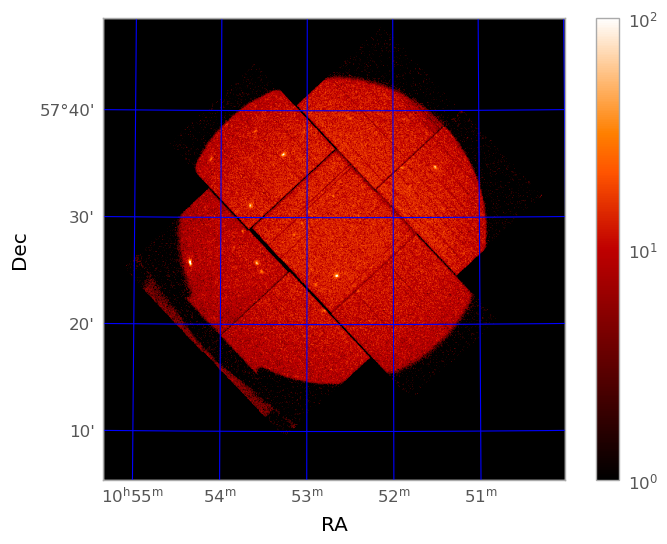

In [6]:
make_fits_image(mos1)

### 6.3 : Apply Standard Filter

To begin we apply a standard filter. The filtering expressions for the MOS and PN are, respectively:
```
(PATTERN $<=$ 12)&&(PI in [200:12000])&&#XMMEA_EM
```
and
```
(PATTERN $<=$ 4)&&(PI in [200:15000])&&#XMMEA_EP
```
The first two expressions will select good events with `PATTERN` in the 0 to 12 (or 0 to 4) range. The `PATTERN` value is similar the `GRADE` selection for ASCA data, and is related to the number and pattern of the CCD pixels triggered for a given event. The `PATTERN` assignments are: single pixel events: `PATTERN == 0`, double pixel events: `PATTERN in [1:4]`, triple and quadruple events: `PATTERN in [5:12]`.

The second keyword in the expressions, `PI`, selects the preferred pulse height of the event; for the MOS, this should be between 200 and 12000 eV. For the PN, this should be between 200 and 15000 eV. This should clean up the image significantly with most of the rest of the obvious contamination due to low pulse height events. Setting the lower `PI` channel limit somewhat higher (e.g., to 300 eV) will eliminate much of the rest.

Finally, the `#XMMEA_EM` (`#XMMEA_EP` for the PN) filter provides a canned screening set of `FLAG` values for the event. The `FLAG` value provides a bit encoding of various event conditions, e.g., near hot pixels or outside of the field of view. Setting `FLAG == 0` in the selection expression provides the most conservative screening criteria and should always be used when serious spectral analysis is to be done on the PN. It typically is not necessary for the MOS.

It is a good idea to keep the output filtered event files and use them in your analyses, as opposed to re-filtering the original file with every task. This will save much time and computer memory. As an example, the Lockman Hole data's original event file is 48.4 Mb; the fully filtered list (that is, filtered spatially, temporally, and spectrally) is only 4.0Mb!

The input arguments to `evselect` to apply the filter are:

    table - input event table
    filtertype - method of filtering
    expression - filtering expression
    withfilteredset - create a filtered set
    filteredset - output file name
    keepfilteroutput - save the filtered output
    updateexposure - update exposure information in event list and in spectrum files
    filterexposure - filter exposure extensions of event list with same time

In [7]:
filtered_event_list = 'mos1_filt.fits'

inargs = ['table={0}'.format(mos1), 
          'withfilteredset=yes', 
          "expression='(PATTERN <= 12)&&(PI in [200:4000])&&#XMMEA_EM'", 
          'filteredset={0}'.format(filtered_event_list), 
          'filtertype=expression', 
          'keepfilteroutput=yes', 
          'updateexposure=yes', 
          'filterexposure=yes']

w('evselect', inargs).run()

Executing: 
evselect table='/home/rtanner2/xmm_data/0123700101/work/0070_0123700101_EMOS1_S001_ImagingEvts.ds' keepfilteroutput='yes' withfilteredset='yes' filteredset='mos1_filt.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='(PATTERN <= 12)&&(PI in [200:4000])&&#XMMEA_EM' writedss='no' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbi

<div class="alert alert-block alert-info">
    <b>Note:</b> The expression for the input <tt>expression</tt> contains single quotes ('text'). The entire string needs to be surrounded by double quotes ("text") to preserve the single quotes inside the string. i.e. "This text has 'single quotes' inside of the double quotes."
</div>

Now we plot the filtered image. It should have less noise now.

Executing: 
evselect table='mos1_filt.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='image.fits' xcolumn='X' ycolumn='Y' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset='no' ratese

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 51661.690498 from DATE-END'. [astropy.wcs.wcs]


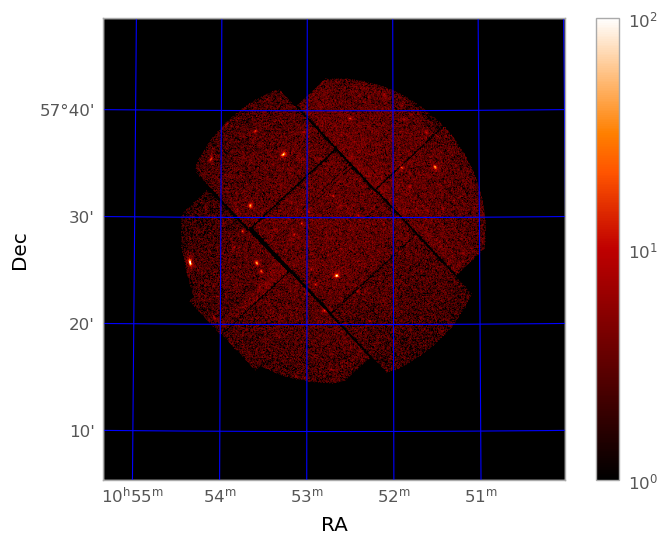

In [8]:
make_fits_image(filtered_event_list)

### 6.4 : Create Light Curve

Sometimes, it is necessary to use filters on time in addition to those mentioned above. This is because of soft proton background flaring, which can have count rates of 100 counts/sec or higher across the entire bandpass. It should be noted that the amount of flaring that needs to be removed depends in part on the object observed; a faint, extended object will be more affected than a very bright X-ray source.

To see if background flaring should be removed we plot and examine the light curve.

Executing: 
evselect table='mos1_filt.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset='yes' 

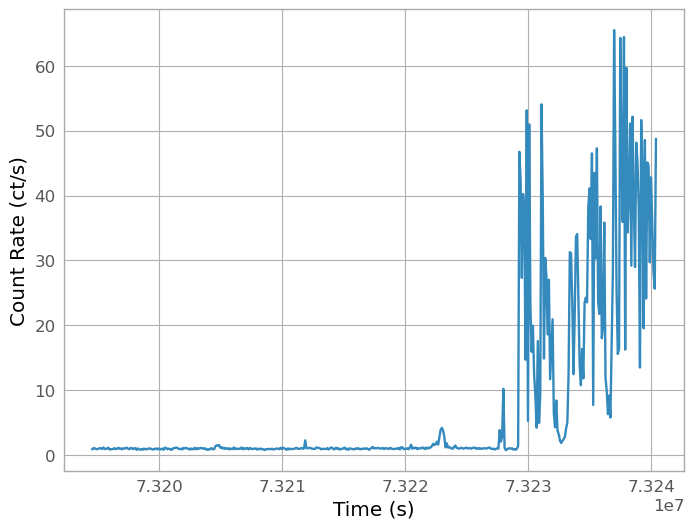

In [9]:
light_curve_file='mos1_ltcrv.fits'
plot_light_curve(filtered_event_list, light_curve_file=light_curve_file)

Taking a look at the light curve, we can see that there is a very large flare toward the end of the observation and two much smaller ones in the middle of the exposure. Examining the light curve shows us that during non-flare times, the count rate is quite low, about 1.3 ct/s, with a small increase at 7.3223e7 seconds to about 6 ct/s. We can use that to further filter the data.

### 6.5 Applying Time or Rate Filters to the Data

There are many ways to filter the data. We will demonstrate four different methods. The first three methods will create a Good Time Interval (GTI) file which can then be used as an input to the command `evselect`. This will create a new, filtered, event list.

1. Create a secondary GTI file using the command `tabgtigen` and filter on `RATE`.
2. Create a secondary GTI file using the command `tabgtigen` and filter on `TIME`.
3. Create a *new* GTI file using the command `gtibuild` and filter on `TIME`.
4. Filter on `TIME` using an explicit reference in the inputs to the command `evselect`.

For the last method the user explicitly inputs the time intervals to be used as an expression for the command `evselect` rather than using a separate GTI file. All of these will get the job done, so which to use is a matter of the user's preference.

#### 6.5.1 Using `tabgtigen` to filter on `RATE`

The inputs for `tabgtigen` are:

    table - input file name with count rate table
    gtiset - output file name for selected GTI intervals
    timecolumn - time column
    expression - filtering expression
    
We choose a rate $<= 6$ counts/s and filter based on that. As the input we use the lightcurve file created in §6.4.

In [10]:
gti_rate_file = 'gti_rate.fits'
mos1_filt_rate = 'mos1_filt_rate.fits'

inargs = ['table={0}'.format(light_curve_file), 
          'gtiset={0}'.format(gti_rate_file),
          'timecolumn=TIME', 
          "expression='(RATE <= 6)'"]

w('tabgtigen', inargs).run()

inargs = ['table={0}'.format(filtered_event_list),
          'withfilteredset=yes', 
          "expression='GTI({0},TIME)'".format(gti_rate_file), 
          'filteredset={0}'.format(mos1_filt_rate),
          'filtertype=expression', 
          'keepfilteroutput=yes',
          'updateexposure=yes', 
          'filterexposure=yes']

w('evselect', inargs).run()

Executing: 
tabgtigen table='mos1_ltcrv.fits' gtiset='gti_rate.fits' expression='(RATE <= 6)' timecolumn='TIME' prefraction='0.5' postfraction='0.5' mingtisize='0.0' 
tabgtigen:- Executing (routine): tabgtigen table=mos1_ltcrv.fits gtiset=gti_rate.fits expression='(RATE <= 6)' timecolumn=TIME prefraction=0.5 postfraction=0.5 mingtisize=0  -w 1 -V 4
tabgtigen:- tabgtigen (tabgtigen-2.13)  [xmmsas_20211130_0941-20.0.0] started:  2024-02-06T17:25:53.000
tabgtigen:- tabgtigen (tabgtigen-2.13)  [xmmsas_20211130_0941-20.0.0] ended:    2024-02-06T17:25:53.000
Executing: 
evselect table='mos1_filt.fits' keepfilteroutput='yes' withfilteredset='yes' filteredset='mos1_filt_rate.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='GTI(gti_rate.fits,TIME)' writedss='no' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EW

Now we create an image from the new event list that has been filtered based on `RATE`. There should be significantly less noise and only point sources should remain. Compare this final image to the first raw, unfilted image.

Executing: 
evselect table='mos1_filt_rate.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='final_image1.fits' xcolumn='X' ycolumn='Y' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 51661.690498 from DATE-END'. [astropy.wcs.wcs]


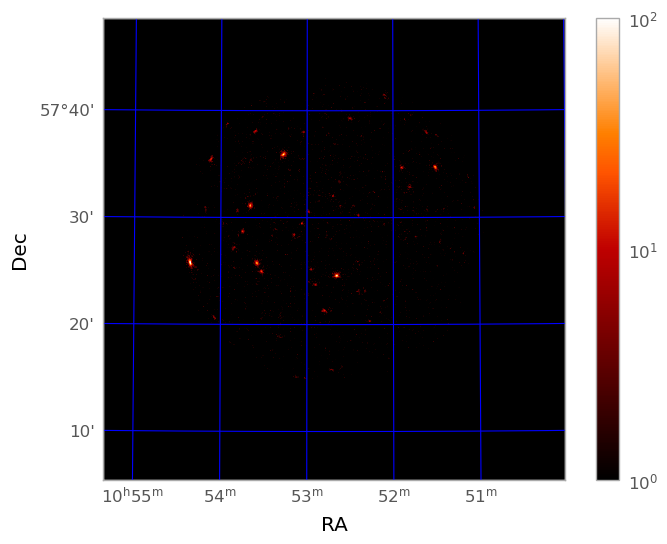

In [11]:
make_fits_image(mos1_filt_rate, image_file='final_image1.fits')

We can also create a new light curve from the filtered event list and compare it to the light curve from §6.4 to see what we have done.

Executing: 
evselect table='mos1_filt_rate.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset='

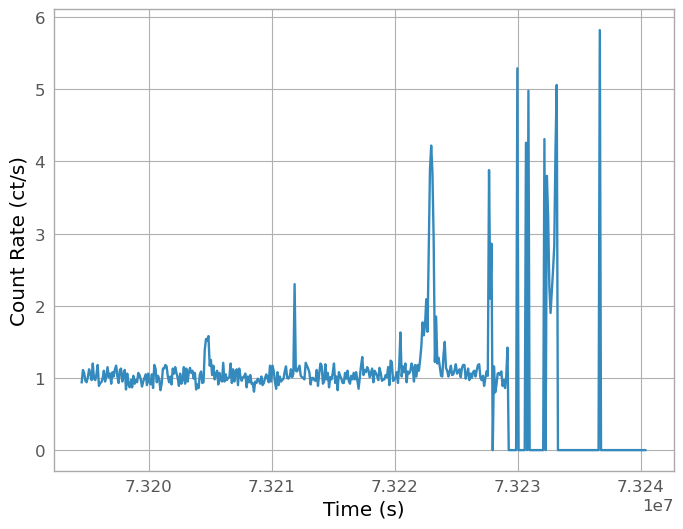

In [12]:
plot_light_curve(mos1_filt_rate)

#### 6.5.2 Using `tabgtigen` to filter on `TIME`

Alternatively, we could have chosen to make a new GTI file by noting the times of the flaring in the light curve and using that as a filtering parameter. The big flare starts around 7.32276e7 s, and the smaller ones are at 7.32119e7 s and 7.32205e7 s. The expression to remove these would be `(TIME <= 73227600)&&!(TIME IN [7.32118e7:7.3212e7])&&!(TIME IN [7.32204e7:7.32206e7])`. The syntax `(TIME <= 73227600)` includes only events with times less than or equal to `73227600`, and the "!" symbol stands for the logical "not", so use `&&!(TIME in [7.32118e7:7.3212e7])` to exclude events in that time interval. Once the new GTI file is made, we apply it with `evselect`. Everything else remains the same as in §6.5.1.

In [13]:
gti_time_file = 'gti_rate.fits'
mos1_filt_time = 'mos1_filt_time.fits'

inargs = ['table={0}'.format(light_curve_file), 
          'gtiset={0}'.format(gti_time_file),
          'timecolumn=TIME', 
          "expression='(TIME <= 73227600)&&!(TIME IN [7.32118e7:7.3212e7])&&!(TIME IN [7.32204e7:7.32206e7])'"]

w('tabgtigen', inargs).run()

inargs = ['table={0}'.format(filtered_event_list),
          'withfilteredset=yes', 
          "expression='GTI({0},TIME)'".format(gti_time_file), 
          'filteredset={0}'.format(mos1_filt_time),
          'filtertype=expression', 
          'keepfilteroutput=yes',
          'updateexposure=yes', 
          'filterexposure=yes']

w('evselect', inargs).run()

Executing: 
tabgtigen table='mos1_ltcrv.fits' gtiset='gti_rate.fits' expression='(TIME <= 73227600)&&!(TIME IN [7.32118e7:7.3212e7])&&!(TIME IN [7.32204e7:7.32206e7])' timecolumn='TIME' prefraction='0.5' postfraction='0.5' mingtisize='0.0' 
tabgtigen:- Executing (routine): tabgtigen table=mos1_ltcrv.fits gtiset=gti_rate.fits expression='(TIME <= 73227600)&&!(TIME IN [7.32118e7:7.3212e7])&&!(TIME IN [7.32204e7:7.32206e7])' timecolumn=TIME prefraction=0.5 postfraction=0.5 mingtisize=0  -w 1 -V 4
tabgtigen:- tabgtigen (tabgtigen-2.13)  [xmmsas_20211130_0941-20.0.0] started:  2024-02-06T17:26:13.000
tabgtigen:- tabgtigen (tabgtigen-2.13)  [xmmsas_20211130_0941-20.0.0] ended:    2024-02-06T17:26:13.000
Executing: 
evselect table='mos1_filt.fits' keepfilteroutput='yes' withfilteredset='yes' filteredset='mos1_filt_time.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='GTI(gti_rate.fits,TIME)' writedss='no' cleandss='no' updateexposure='yes' 

We can now plot the image that has been filtered on `TIME` and compare it to the image that was been filtered on `RATE` from §6.5.1.

Executing: 
evselect table='mos1_filt_time.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='final_image2.fits' xcolumn='X' ycolumn='Y' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 51661.690498 from DATE-END'. [astropy.wcs.wcs]


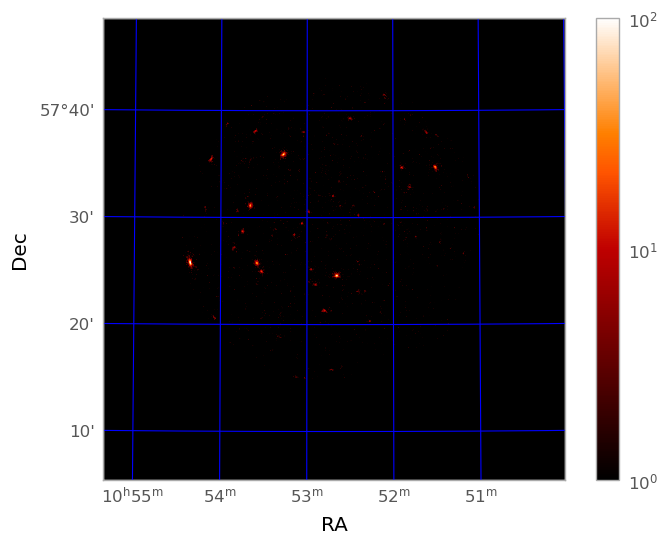

Executing: 
evselect table='mos1_filt_time.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset='

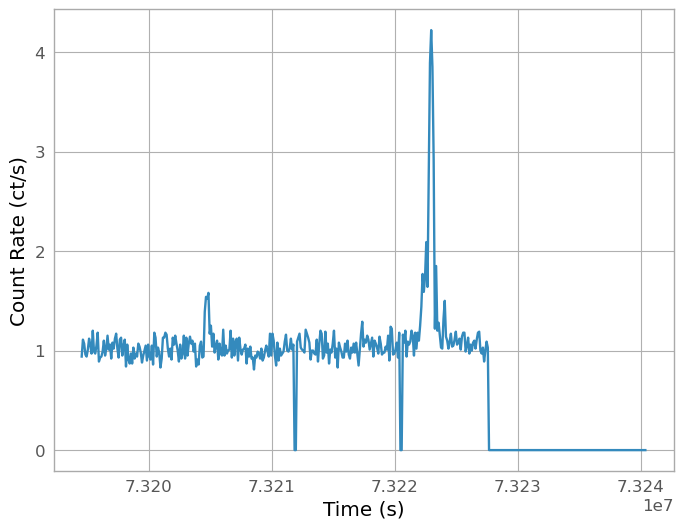

In [14]:
make_fits_image(mos1_filt_time, image_file='final_image2.fits')
plot_light_curve(mos1_filt_time)

#### 6.5.3 Using `gtibuild` to make a new GTI file and filter on `TIME`

This method requires a text file as input. The file should be in ASCII format with eash row on a new line and values for each column separated by spaces. In the first two columns, enter the start and end times (in seconds) that you are interested in, and in the third column, indicate with either a + or - sign whether that region should be kept or removed. Each good (or bad) time interval should get its own line, with any optional comments preceeded by a "#". In the example case, we would write in our ASCII file (named gti.txt):

In [15]:
gti_lines = ['0        73227600 + # Good time from the start of the observation',
             '73211800 73212000 - # But without a small flare here.',
             '73211800 73212000 - # And here.']

with open('gti.txt', 'w') as f:
    f.writelines(gti_lines)

We can now run `gtibuild` to create a new GTI file.

---
The inputs for `gtibuild` are:

    file - input text file name
    table - output GTI file name

In [16]:
gti_txt_file = 'gti.txt'
new_gti_file = 'new_gti.fits'
mos1_new_gti = 'mos1_new_gti.fits'

inargs = ['file={0}'.format(gti_txt_file),
          'table={0}'.format(new_gti_file)]

w('gtibuild', inargs).run()

Executing: 
gtibuild file='gti.txt' table='new_gti.fits' 
gtibuild:- Executing (routine): gtibuild file=gti.txt table=new_gti.fits  -w 1 -V 4
gtibuild:- gtibuild (gtibuild-1.5)  [xmmsas_20211130_0941-20.0.0] started:  2024-02-06T17:26:28.000
gtibuild:- gtibuild (gtibuild-1.5)  [xmmsas_20211130_0941-20.0.0] ended:    2024-02-06T17:26:28.000


We can now run `evselect` as before with the new GTI file.

In [17]:
inargs = ['table={0}'.format(filtered_event_list),
          'withfilteredset=yes', 
          "expression='GTI({0},TIME)'".format(new_gti_file), 
          'filteredset={0}'.format(mos1_new_gti),
          'filtertype=expression', 
          'keepfilteroutput=yes',
          'updateexposure=yes', 
          'filterexposure=yes']

w('evselect', inargs).run()

Executing: 
evselect table='mos1_filt.fits' keepfilteroutput='yes' withfilteredset='yes' filteredset='mos1_new_gti.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='GTI(new_gti.fits,TIME)' writedss='no' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec=

If you want, you can compare the new image and light curve to what was made previously.

Executing: 
evselect table='mos1_new_gti.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='final_image3.fits' xcolumn='X' ycolumn='Y' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset='

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 51661.690498 from DATE-END'. [astropy.wcs.wcs]


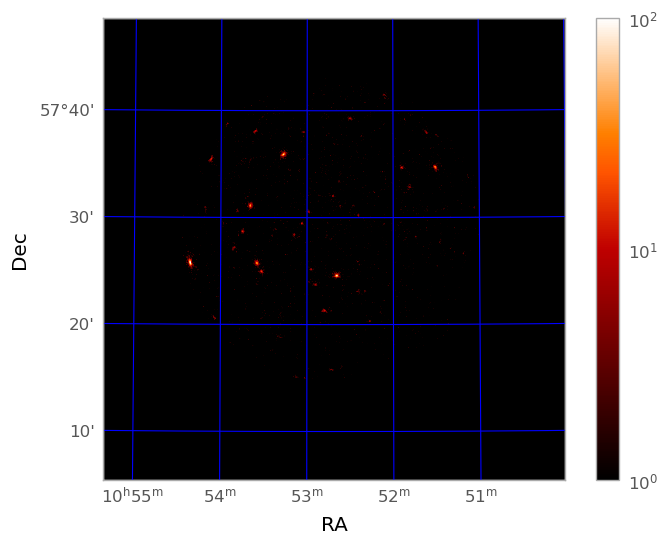

Executing: 
evselect table='mos1_new_gti.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset='ye

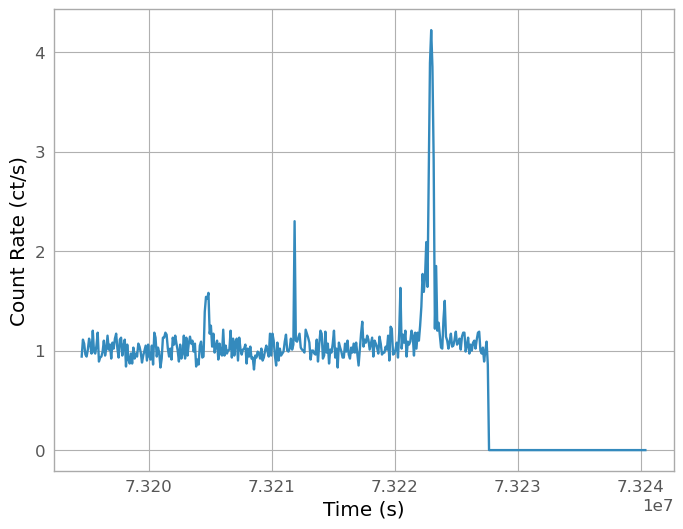

In [18]:
make_fits_image(mos1_new_gti, image_file='final_image3.fits')
plot_light_curve(mos1_new_gti)

#### 6.5.4 Filter on `TIME` by Explicit Reference

Finally, we could have chosen to forgo making a secondary GTI file altogether, and simply filtered on `TIME` with the standard filtering expression (see §6.3). The filtering expression from §6.3 can be combined with the filtering expression from §6.5.2 and filter the raw data all in one step. In this case, the full filtering expression would be:

In [20]:
expression = "expression='(PATTERN <= 12)&&(PI in [200:12000])&&#XMMEA_EM&&(TIME <= 73227600) &&!(TIME IN [7.32118e7:7.3212e7])&&!(TIME IN [7.32204e7:7.32206e7])'"

and we would run `evselect` as the same way we did in §6.3.

In [21]:
full_filt_event_list = 'mos1_filt.fits'

inargs = ['table={0}'.format(mos1), 
          'withfilteredset=yes', 
          expression, 
          'filteredset={0}'.format(full_filt_event_list), 
          'filtertype=expression', 
          'keepfilteroutput=yes', 
          'updateexposure=yes', 
          'filterexposure=yes']

w('evselect', inargs).run()

Executing: 
evselect table='/home/rtanner2/xmm_data/0123700101/work/0070_0123700101_EMOS1_S001_ImagingEvts.ds' keepfilteroutput='yes' withfilteredset='yes' filteredset='mos1_filt.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='(PATTERN <= 12)&&(PI in [200:12000])&&#XMMEA_EM&&(TIME <= 73227600) &&!(TIME IN [7.32118e7:7.3212e7])&&!(TIME IN [7.32204e7:7.32206e7])' writedss='no' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimage

Finally we can compare the result with what we made before.

Executing: 
evselect table='mos1_filt.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='final_image4.fits' xcolumn='X' ycolumn='Y' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset='no'

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 51661.690498 from DATE-END'. [astropy.wcs.wcs]


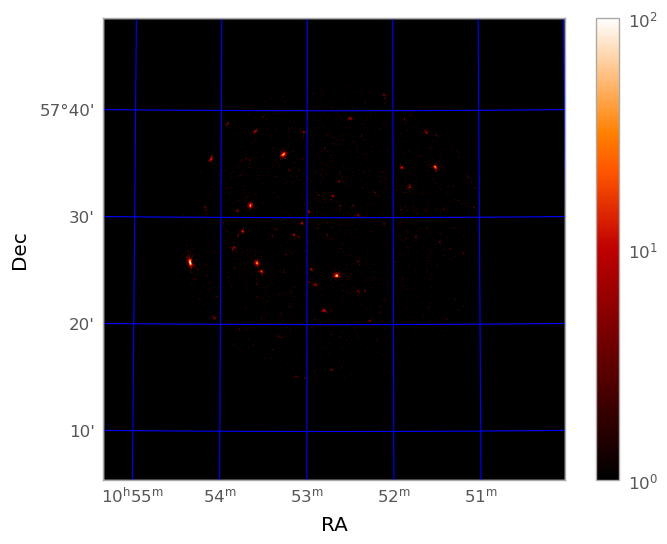

Executing: 
evselect table='mos1_filt.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset='yes' 

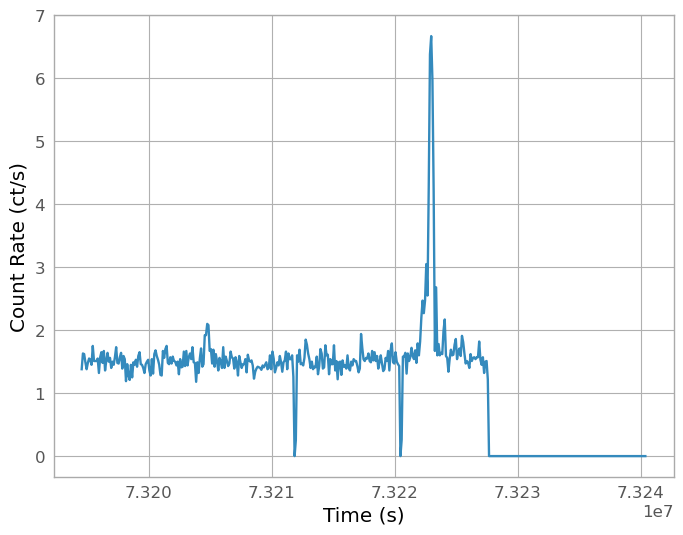

In [22]:
make_fits_image(full_filt_event_list, image_file='final_image4.fits')
plot_light_curve(full_filt_event_list)

### Conclusion

We have demonstrated various filtering techniques to remove noise from the raw observation data. In Part 2 we will cover source detection, spectra extraction, pile up, and preparing the spectra for analysis by creating a redistribution matrix file (RMF) and an ancillary response file (ARF).

---

Below we have included a short script that incorporates all of the filtering steps for a single observation for MOS1, but without making any plots or image files.

In [23]:
obsid = '0123700101'
odf = pysas.odfcontrol.ODFobject(obsid)
odf.basic_setup(overwrite=False,repo='heasarc',
                rerun=False, epproc_args=['withoutoftime=yes'])

os.chdir(odf.work_dir)
unfiltered_event_list = odf.files['m1evt_list'][0]

# The User can change these file names
temporary_event_list = 'temporary_event_list.fits' # Created by the "standard" filter
light_curve_file = 'mos1_ltcrv.fits'               # Light curve file name
gti_rate_file = 'gti_rate.fits'                    # GTI file name
filtered_event_list = 'filtered_event_list.fits'   # Final filtered 

# "Standard" Filter
inargs = ['table={0}'.format(unfiltered_event_list), 
          'withfilteredset=yes', 
          "expression='(PATTERN <= 12)&&(PI in [200:4000])&&#XMMEA_EM'", 
          'filteredset={0}'.format(temporary_event_list), 
          'filtertype=expression', 
          'keepfilteroutput=yes', 
          'updateexposure=yes', 
          'filterexposure=yes']

w('evselect', inargs).run()

# Make Light Curve File
inargs = ['table={0}'.format(temporary_event_list), 
          'withrateset=yes', 
          'rateset={0}'.format(light_curve_file), 
          'maketimecolumn=yes', 
          'timecolumn=TIME', 
          'timebinsize=100', 
          'makeratecolumn=yes']

w('evselect', inargs).run()

# Make Secondary GTI File
inargs = ['table={0}'.format(light_curve_file), 
          'gtiset={0}'.format(gti_rate_file),
          'timecolumn=TIME', 
          "expression='(RATE <= 6)'"]

w('tabgtigen', inargs).run()

# Filter Using Secondary GTI File
inargs = ['table={0}'.format(temporary_event_list),
          'withfilteredset=yes', 
          "expression='GTI({0},TIME)'".format(gti_rate_file), 
          'filteredset={0}'.format(filtered_event_list),
          'filtertype=expression', 
          'keepfilteroutput=yes',
          'updateexposure=yes', 
          'filterexposure=yes']

w('evselect', inargs).run()



        Starting SAS session

        Data directory = /home/rtanner2/xmm_data

        
SAS_CCF = /home/rtanner2/xmm_data/0123700101/work/ccf.cif
SAS_ODF = /home/rtanner2/xmm_data/0123700101/work/0070_0123700101_SCX00000SUM.SAS
['withoutoftime=yes']
   SAS command to be executed: epproc, with arguments; 
['withoutoftime=yes']
Running epproc ..... 

 > 1 EPIC-pn event list found. Not running epproc again.

    /home/rtanner2/xmm_data/0123700101/work/0070_0123700101_EPN_S003_ImagingEvts.ds

..... OK
[]
   SAS command to be executed: emproc, with arguments; 
[]
Running emproc ..... 

 > 2 EPIC-MOS1 event list found. Not running emproc again.

    /home/rtanner2/xmm_data/0123700101/work/0070_0123700101_EMOS1_S001_ImagingEvts.ds

    /home/rtanner2/xmm_data/0123700101/work/0070_0123700101_EMOS1_U002_ImagingEvts.ds

 > 1 EPIC-MOS2 event list found. Not running emproc again.

    /home/rtanner2/xmm_data/0123700101/work/0070_0123700101_EMOS2_S002_ImagingEvts.ds

..... OK
Executing: 
evselec